<a href="https://colab.research.google.com/github/roydendsouza31/AI-Generated-Images-vs-Real-Images/blob/A1/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AI Generated Images vs Real Images

In [73]:
from google.colab import drive
drive.mount('/content/drive')

!pip install kaggle

import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

import zipfile

# Define the path to your zip file
file_path = '/content/cifake-real-and-ai-generated-synthetic-images.zip'  # Replace 'your_file.zip' with your file's name

!mkdir CIFAKE

# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/CIFAKE')  # Replace 'destination_folder' with your desired folder

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cifake-real-and-ai-generated-synthetic-images.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘CIFAKE’: File exists


In [74]:
dataset_dir = "/content/CIFAKE" # For Kaggle notebooks. If you run locally, point this line to the CIFAKE directory
print("Loading dataset from: " + dataset_dir)

Loading dataset from: /content/CIFAKE


In [92]:
# Import all of the data using dataset from directory
# If there isn't enough RAM available, consider using Tensorflow Datasets

import tensorflow as tf

img_height = 32 # The dataset is all 32px but this is here just to make sure
img_width = 32
batch_size = 64

# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "/train",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Load the validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "/test",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Quick sanity check to make sure it's all loaded properly
print("Training Classes:")
class_names = train_ds.class_names
print(class_names)

print("Testing Classes:")
class_names = train_ds.class_names
print(class_names)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Training Classes:
['FAKE', 'REAL']
Testing Classes:
['FAKE', 'REAL']


In [98]:
import tensorflow as tf

# Define the CNN layers
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),  # Normalise pixel values
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),  # Add Dropout layer to prevent overfitting
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Build the model to see a summary
model.build(input_shape=(None, 32, 32, 3))
model.summary()




Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 32, 32, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_19 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_11 (Flatten)        (None, 6272)              0         
                                                                 
 dropout_3 (Dropout)         (None, 6272)              0         
                                                     

In [99]:
# Check if GPUs are available for training
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [100]:
# Finally, train the model

print("Starting training...")
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15,
  verbose=1
)

# !mkdir TrainedModelSave
# model.save("/content/TrainedModelSave") # Saving the model

print("Training finished.")

Starting training...
Epoch 1/15
1563/1563 [==============================] - 21s 12ms/step - loss: 0.3268 - accuracy: 0.8555 - precision_11: 0.8480 - recall_11: 0.8663 - val_loss: 0.2167 - val_accuracy: 0.9159 - val_precision_11: 0.9229 - val_recall_11: 0.9076
Epoch 2/15
1563/1563 [==============================] - 17s 11ms/step - loss: 0.2151 - accuracy: 0.9141 - precision_11: 0.9122 - recall_11: 0.9163 - val_loss: 0.1917 - val_accuracy: 0.9213 - val_precision_11: 0.8963 - val_recall_11: 0.9528
Epoch 3/15
1563/1563 [==============================] - 17s 11ms/step - loss: 0.1822 - accuracy: 0.9280 - precision_11: 0.9281 - recall_11: 0.9279 - val_loss: 0.1596 - val_accuracy: 0.9388 - val_precision_11: 0.9357 - val_recall_11: 0.9425
Epoch 4/15
1563/1563 [==============================] - 20s 13ms/step - loss: 0.1632 - accuracy: 0.9358 - precision_11: 0.9362 - recall_11: 0.9353 - val_loss: 0.1691 - val_accuracy: 0.9323 - val_precision_11: 0.9540 - val_recall_11: 0.9085
Epoch 5/15
1563/156

In [102]:
# Evaluate the model on the test dataset
loss, accuracy, precision, recall = model.evaluate(val_ds)

# Print the evaluation metrics
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")


313/313 [==============================] - 4s 12ms/step - loss: 0.1573 - accuracy: 0.9424 - precision_11: 0.9350 - recall_11: 0.9510
Test Loss: 0.15732809901237488
Test Accuracy: 0.9424499869346619
Test Precision: 0.9350113272666931
Test Recall: 0.9509999752044678


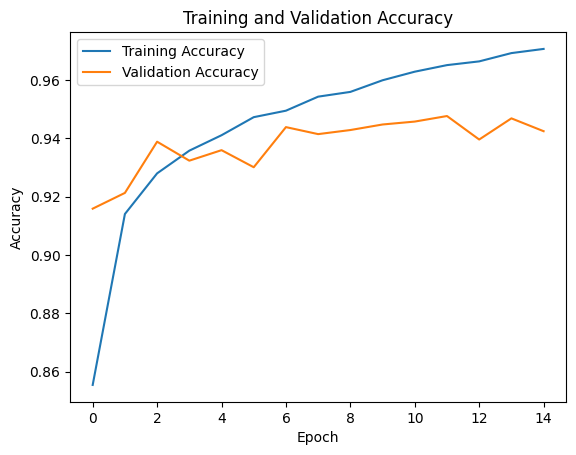

In [103]:
# Plot training and validation accuracy on the same plot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()